In [ ]:
from tqdm import tqdm
from array_lib import *
from point3d_lib import Point
from collections import defaultdict
from skeleton3d_lib import Skeleton
from sklearn.cluster import KMeans
from ply_creation_lib import create_ply
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
import pydicom as dicom
import numpy as np
import cv2 as cv
import shutil
import pickle
import copy
import os

In [ ]:
def read_dicom(input_folder: str) -> np.ndarray:
    files: list[str] = os.listdir(input_folder)
    data = [dicom.dcmread(f'{input_folder}\\{file}') for file in files if file.endswith('.dcm')]
    image = np.array([dicom.pixel_array(datum) for datum in data])
    return image

def normalize_image_colors(image: np.ndarray) -> np.ndarray:
    image = copy.deepcopy(image)
    min_val = np.min(image)
    max_val = np.max(image)
    image = (image - min_val) / (max_val - min_val) * 255
    return image

def read_annotations(annotation_file: str):
    return np.load(f'annotations\\{annotation_file}')

def create_skeleton_ply(annotation_mask: np.ndarray, skeleton_points: Skeleton, ply_name: str):
    reduced_skeleton = np.zeros_like(annotation_mask).astype(bool)
    reduced_skeleton[skeleton_points[:, 0], skeleton_points[:, 1], skeleton_points[:, 2]] = True
    create_ply(reduced_skeleton, ply_name)

In [ ]:
input_folder = '20250222_37'
draw_mask = True

annotation_file = f'{input_folder}_annotation.npy'
min_skeleton_length = 100



output_folder = f'{os.getcwd()}/plane_MPR/{input_folder}'
if draw_mask:
    output_folder += '_annotated'

In [5]:
image = read_dicom(input_folder)
normalized_image = normalize_image_colors(image)

annotation_mask = read_annotations(annotation_file)
# create_ply(annotation_mask, '1_annotation.ply')

skeleton_mask = skeletonize(annotation_mask)
create_ply(skeleton_mask, '2_skeleton.ply')

100%|███████████████████████████████████████████████████████| 1675/1675 [00:00<00:00, 151964.25it/s]


In [6]:
selected_skeletons = find_skeletons(skeleton_mask)
skeleton_points = np.concatenate(selected_skeletons)
filtered_skeleton_mask = np.zeros_like(skeleton_mask).astype(bool)
filtered_skeleton_mask[skeleton_points[:, 0], skeleton_points[:, 1], skeleton_points[:, 2]] = True
create_ply(filtered_skeleton_mask, '3_filtered.ply')

	--labeling: 1.407s
	--dividing blobs: 0.658s


100%|███████████████████████████████████████████████████████| 1627/1627 [00:00<00:00, 147887.76it/s]


In [7]:
skeletons: list[Skeleton] = []
for i, chosen_skeleton in enumerate(selected_skeletons):
    skeleton = Skeleton()
    skeleton.create(chosen_skeleton, filtered_skeleton_mask)
    skeletons.append(skeleton)

    skel_data = skeleton.to_numpy()
    create_skeleton_ply(annotation_mask, skel_data, f'3_skeleton{i}.ply')

midpoint: [378.38386308 204.44376528 157.10391198]
3
[363 339 236] (1)


100%|█████████████████████████████████████████████████████████| 818/818 [00:00<00:00, 136343.22it/s]


midpoint: [233.66832918 237.68453865 339.38653367]
1
[133 278 280] (3)


100%|█████████████████████████████████████████████████████████| 802/802 [00:00<00:00, 114544.62it/s]


In [8]:
print(len(skeletons))
branches: list[Skeleton] = []
for skeleton in skeletons:
    these_branches = skeleton.split_into_branches(min_skeleton_length)
    if these_branches is not None:
        branches.extend(these_branches)

2


In [9]:
print(len(branches))
for i, skeleton in enumerate(branches):
    branch_points = np.array([list(i.coordinates) for i in skeleton.points])
    create_skeleton_ply(annotation_mask, branch_points, f'4_branch{i}.ply')

4


100%|██████████████████████████████████████████████████████████| 142/142 [00:00<00:00, 66785.28it/s]


In [10]:
def fit_plane_first_last(skeleton: np.ndarray):
    middle_point = skeleton[len(skeleton)//2]
    first_point = skeleton[0]
    last_point = skeleton[-1]
    
    vector1 = first_point - middle_point
    vector2 = last_point - middle_point
    normal = np.cross(vector1, vector2)
    return normal / np.linalg.norm(normal)

def get_flow_vector(skeleton: np.ndarray):
    middle_point_id = len(skeleton)//2
    flow_vector = skeleton[middle_point_id+1] - skeleton[middle_point_id-1]
    return flow_vector / np.linalg.norm(flow_vector)

def project_vector(n: np.ndarray, v: np.ndarray):
    projected = v - (np.dot(v, n) / np.dot(n, n) * n)
    return projected / np.linalg.norm(projected)

def rotate_vector(f: np.ndarray, n: np.ndarray, degrees: float):
    rad_angle = np.radians(degrees)
    
    add1 = n * np.cos(rad_angle)
    add2 = np.cross(f, n) * np.sin(rad_angle)
    add3 = np.dot(f, n) * (1 - np.cos(rad_angle)) * f
    return add1 + add2 + add3

def calculate_view_angle(plane_normal):
    normal = np.array(plane_normal) / np.linalg.norm(plane_normal)
    azimuth = np.degrees(np.arctan2(normal[1], normal[0]))
    elevation = np.degrees(np.arcsin(normal[2]))
    return elevation, azimuth

def project_to_2d(points, normal):
    normal = normal / np.linalg.norm(normal)
    u = np.cross(normal, [1, 0, 0])
    if np.linalg.norm(u) < 1e-6:
        u = np.cross(normal, [0, 1, 0])
    v = np.cross(normal, u)
    
    u, v = u / np.linalg.norm(u), v / np.linalg.norm(v)
    return np.array([[np.dot(p, u), np.dot(p, v)] for p in points])

def calc_rot_matrix(points, custom_angle: int = 0):
    first_point, last_point = points[0], points[-1]
    angle = np.arctan2(last_point[1] - first_point[1], last_point[0] - first_point[0])
    if custom_angle != 0:
        angle += custom_angle * np.pi/180
    rotation_matrix = np.array([
        [np.cos(-angle), -np.sin(-angle)],
        [np.sin(-angle), np.cos(-angle)]
    ])
    return rotation_matrix
    
def apply_rotation(points, matrix: np.ndarray, center = None) -> np.ndarray:
    if center is None:
        center = points[0]
    return (points - center) @ matrix.T

def get_values(image: np.ndarray, coords: np.ndarray):
    x_size, y_size, z_size = image.shape
    coords = np.clip(coords, [0, 0, 0], [x_size-1, y_size-1, z_size-1]).astype(int)
    result = image[coords[:, 0], coords[:, 1], coords[:, 2]]
    return result

def filter_branch(annotations: np.ndarray, skeleton: Skeleton):
    flooded = floodfill_3d_mask(annotations, skeleton[0].coordinates)
    isolated_skeleton = np.zeros_like(flooded).astype(bool)
    for point in skeleton.to_numpy():
        isolated_skeleton[tuple(point)] = True
    isolated_skeleton = dilate_3d(isolated_skeleton, kernel_size=3, iterations=10)
    combined_isolation = np.logical_and(flooded, isolated_skeleton)
    return np.argwhere(combined_isolation)

  0%|                                                                        | 0/72 [00:13<?, ?it/s]


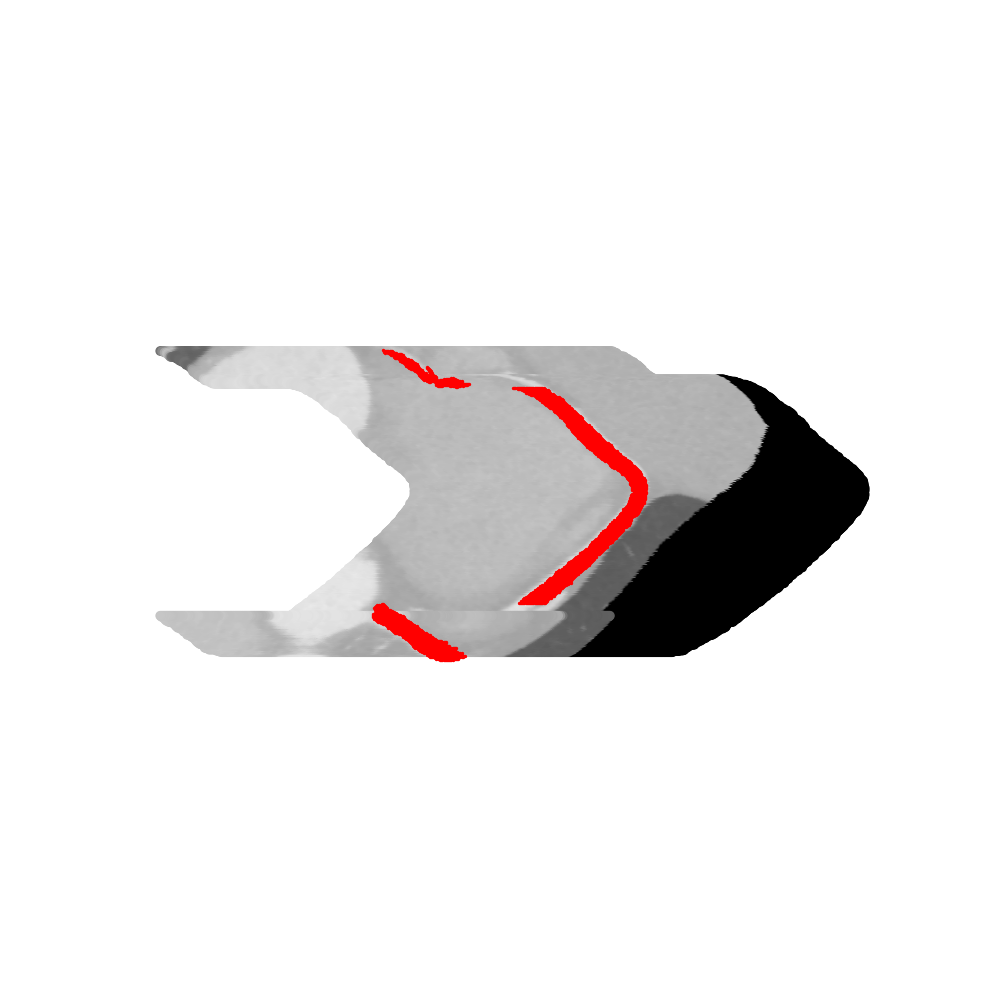

In [94]:
%matplotlib widget
#Calculating and drawing MPR

rotation_degrees = 5
rotations = int(360/rotation_degrees)

if not os.path.exists(output_folder):
    os.mkdir(output_folder)

for b_id, skeleton in enumerate(branches):
    reduced_skeleton = filter_branch(annotation_mask, skeleton)

    branch_specific_output_folder = f'{output_folder}/branch{b_id}'
    if os.path.exists(branch_specific_output_folder):
        shutil.rmtree(branch_specific_output_folder)
    os.mkdir(branch_specific_output_folder)

    original_skeleton = np.array([b.coordinates for b in skeleton])
    middle_point = original_skeleton[len(original_skeleton)//2]
    skeleton = original_skeleton - middle_point

    plane_normal = fit_plane_first_last(skeleton)
    flow_vector = project_vector(plane_normal, get_flow_vector(skeleton))

    plt.style.use('grayscale')
    fig = plt.figure(figsize=(10, 10), frameon=False)
    ax = fig.add_subplot()

    for i in tqdm(range(rotations), ncols=100):
        ax.cla()
        rotated_plane = rotate_vector(flow_vector, plane_normal, i*rotation_degrees)
        
        first_to_last_vector = original_skeleton[-1] - original_skeleton[0]
        perpendicular_vector = np.cross(first_to_last_vector, rotated_plane)
        perpendicular_vector /= np.linalg.norm(perpendicular_vector)
        

        y_step = 1
        steps = np.arange(-200, 201, y_step)
        steps = np.array([(s*perpendicular_vector) for s in steps])
        new_image = np.zeros((len(steps), len(original_skeleton)))

        point_array = []
        color_array = []
        for point in original_skeleton:
            point_coords = steps + point
            point_values = get_values(normalized_image, steps + point).astype(int)

            projected_point_coords = project_to_2d(point_coords, rotated_plane)
            colors = [p for p in point_values]

            point_array.extend(list(projected_point_coords))
            color_array.extend(colors)


        projected_original_skeleton = project_to_2d(original_skeleton, rotated_plane)
        original_pivot = copy.deepcopy(projected_original_skeleton[0])
        # projected_original_skeleton -= original_pivot
        rotation_matrix = calc_rot_matrix(projected_original_skeleton - original_pivot, custom_angle=90)
        point_array = apply_rotation(point_array, rotation_matrix, center=original_pivot)
        ax.scatter(*zip(*point_array), c=color_array)

        # improve the timings


        if draw_mask:
            projected_branch = project_to_2d(reduced_skeleton, rotated_plane)
            projected_branch = apply_rotation(projected_branch, rotation_matrix, center=original_pivot)
            projected_branch = np.array([np.array((int(p[0]), p[1])) for p in projected_branch])

            projected_original_skeleton = apply_rotation(projected_original_skeleton, rotation_matrix, center=original_pivot)

            A = projected_branch.astype(int)
            B = projected_original_skeleton.astype(int)
            # print(len(A))
            # print(B)
            # print(len(B))
            # print(len(np.unique(B)))
            # print(np.unique(B, axis=1))
            # print(len())
            B_list = list(set([tuple(i) for i in B]))

            B_set = np.unique(B, axis=0)
            kmeans = KMeans(n_clusters=len(B_list), init=B_list, n_init=1, max_iter=1)
            kmeans.fit(A)
            closest_indices = kmeans.predict(A)
            sorted_branch = projected_branch[np.argsort(closest_indices)]

            bins = defaultdict(list)
            for i, index in enumerate(closest_indices):
                bins[index].append(tuple(A[i]))




            remade_points = []
            for cluster in reversed(bins.values()):
                cluster = np.array(cluster)
                for slice_y in set([i[1] for i in cluster]):
                    sliced_points = list([(tuple(i), True) for i in cluster[cluster[:,1]==slice_y]])

                    minbin = min(i[0][0] for i in sliced_points)-30
                    maxbin = max(i[0][0] for i in sliced_points)+30
                    minside_points = [((minbin - i, slice_y), False) for i in range(200)]
                    maxside_points = [((maxbin + i, slice_y), False) for i in range(200)]

                    remade_points.extend(minside_points + sliced_points + maxside_points)

            # coords, colors = zip(*remade_points)
            # colors = ['r' if i else 'b' for i in colors]
            # print('a')

            # ax.scatter(*zip(*coords), c=colors, s=1)

            seen = set()
            result = []
            for coord, value in reversed(remade_points):
                if coord not in seen:
                    seen.add(coord)
                    if value:
                        result.append(coord)
            ax.scatter(*zip(*result), c='r', s=2)
        
        ax.set_facecolor('black')
        ax.set_aspect('equal')
        ax.axis('off')

        
        plt.savefig(f"{branch_specific_output_folder}/mpr{i*rotation_degrees}deg.png", dpi=300, pad_inches=0)
        break
    break
